In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# -------------------- 1. Imports --------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention, Concatenate, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# -------------------- 2. Reprodutibilidade --------------------
tf.keras.utils.set_random_seed(42)
tf.keras.backend.clear_session()

# -------------------- 3. Carregar Dataset --------------------
df = pd.read_csv("/content/drive/MyDrive/household_power_consumption.txt", sep=";", na_values="?", low_memory=False)
df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S")
df = df[["Datetime", "Global_active_power", "Global_reactive_power", "Voltage",
         "Global_intensity", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]].dropna()
df = df.set_index("Datetime").resample("H").mean().dropna()

# -------------------- 4. Engenharia de Features Temporais --------------------
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["month"] = df.index.month
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

# -------------------- 5. Normalização --------------------
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# -------------------- 6. Criar Janelas com múltiplos horizontes --------------------
def create_sequences(data, window_size, horizon=24):
    X, y = [], []
    for i in range(len(data) - window_size - horizon):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+horizon, 0])  # target = Global_active_power
    return np.array(X), np.array(y)

window_size = 168  # 7 dias
horizon = 24       # prever 24h
X, y = create_sequences(scaled_data, window_size, horizon)

# -------------------- 7. Treino/Teste --------------------
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# -------------------- 8. Modelo com Attention --------------------
input_layer = Input(shape=(window_size, X.shape[2]))
x = LSTM(128, return_sequences=True)(input_layer)
x = Dropout(0.3)(x)
attention = Attention()([x, x])
x = Concatenate()([x, attention])
x = LayerNormalization()(x)
x = LSTM(64)(x)
x = Dropout(0.3)(x)
output = Dense(horizon)(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mse')

# -------------------- 9. Callbacks --------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)

# -------------------- 10. Treinamento --------------------
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

# -------------------- 11. Previsão --------------------
y_pred = model.predict(X_test)

# -------------------- 12. Desnormalizar --------------------
def inverse_scale(y_scaled, n_features):
    out = []
    for seq in y_scaled:
        seq = seq.reshape(-1, 1)
        extended = np.concatenate([seq, np.zeros((seq.shape[0], n_features - 1))], axis=1)
        inv = scaler.inverse_transform(extended)[:, 0]
        out.append(inv)
    return np.array(out)

y_test_inv = inverse_scale(y_test, X.shape[2])
y_pred_inv = inverse_scale(y_pred, X.shape[2])

<ipython-input-6-87100bd9b62c>:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.set_index("Datetime").resample("H").mean().dropna()


Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.0355 - val_loss: 0.0189 - learning_rate: 0.0010
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0176 - val_loss: 0.0161 - learning_rate: 0.0010
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0156 - val_loss: 0.0154 - learning_rate: 0.0010
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0148 - val_loss: 0.0153 - learning_rate: 0.0010
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0142 - val_loss: 0.0148 - learning_rate: 0.0010
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0137 - val_loss: 0.0149 - learning_rate: 0.0010
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0132 - val_loss: 0.0145 - learning_rate: 0.0010
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0129 - val_loss: 0.0154 - learning_rate: 0.0010
Epoch 9/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0125 - val_loss: 0.0154 - learni

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
MAE: 0.4388896498338856
RMSE: 0.33175583372094025
R²: 0.3680872087943212


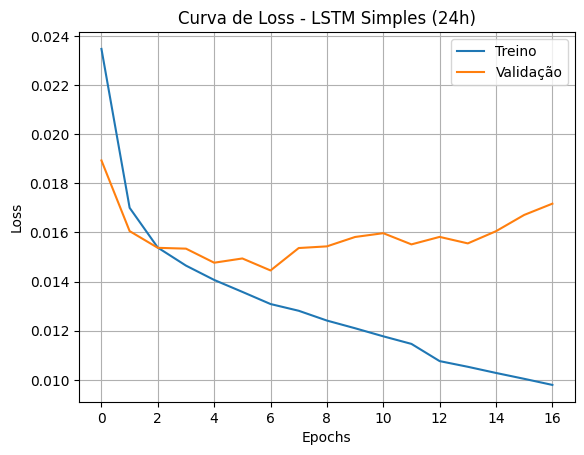

In [7]:
# -------------------- 10. Avaliação --------------------
y_pred = model.predict(X_test)
# y_test e y_pred têm shape (amostras, 24, 1)

def invert_scale(y_scaled, n_features):
    inv = []
    for yseq in y_scaled:
        yseq = yseq.reshape(-1, 1)  # garante shape (24, 1)
        extended = np.concatenate([yseq, np.zeros((yseq.shape[0], n_features - 1))], axis=1)
        inv_seq = scaler.inverse_transform(extended)[:, 0]  # pega só Global_active_power
        inv.append(inv_seq)
    return np.array(inv)

# Aplicar
y_test_inv = invert_scale(y_test, X.shape[2])
y_pred_inv = invert_scale(y_pred, X.shape[2])


mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = mean_squared_error(y_test_inv, y_pred_inv,)
r2 = r2_score(y_test_inv, y_pred_inv)

print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

# -------------------- 11. Plot da Curva de Loss --------------------
plt.plot(history.history["loss"], label="Treino")
plt.plot(history.history["val_loss"], label="Validação")
plt.title("Curva de Loss - LSTM Simples (24h)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-8-cc2a5a66d45b>:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


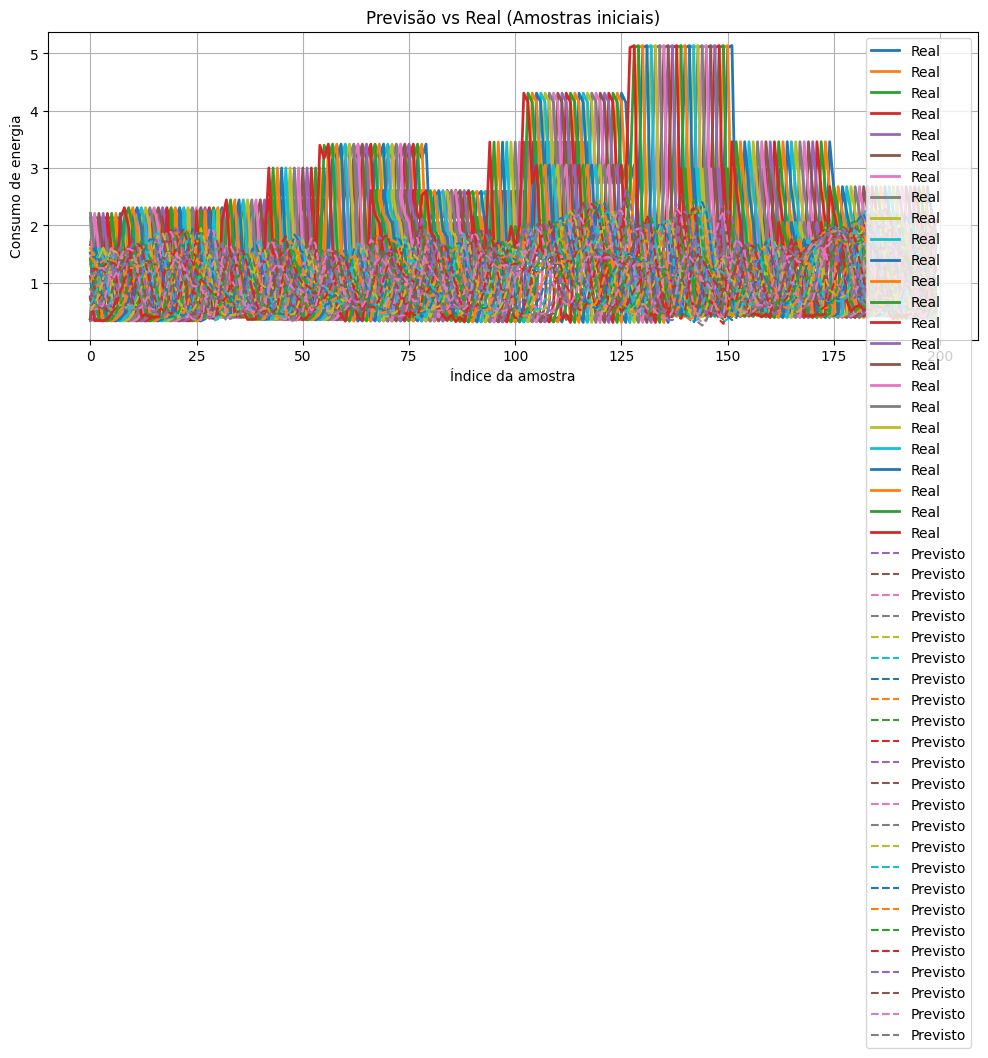

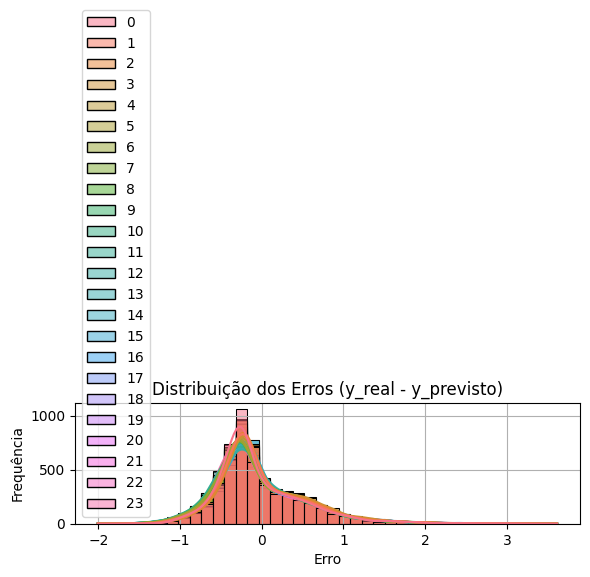

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

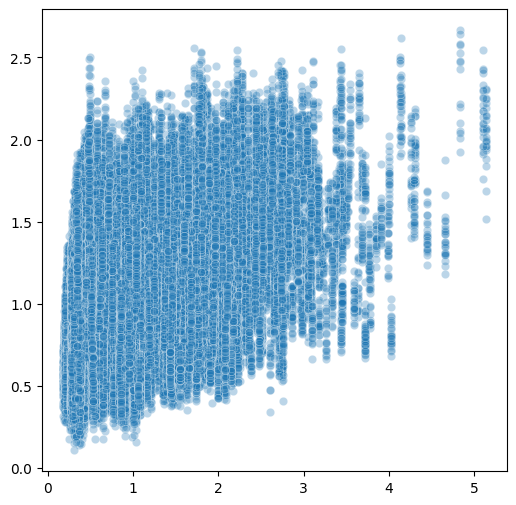

In [8]:
import seaborn as sns

# Gráfico 1: Curva de previsão (real vs previsto)
plt.figure(figsize=(12, 4))
plt.plot(y_test_inv[:200], label='Real', linewidth=2)
plt.plot(y_pred_inv[:200], label='Previsto', linestyle='--')
plt.title('Previsão vs Real (Amostras iniciais)')
plt.xlabel('Índice da amostra')
plt.ylabel('Consumo de energia')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 2: Histograma dos erros
errors = y_test_inv - y_pred_inv
plt.figure(figsize=(6, 4))
sns.histplot(errors, kde=True, bins=40, color='gray')
plt.title('Distribuição dos Erros (y_real - y_previsto)')
plt.xlabel('Erro')
plt.ylabel('Frequência')
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 3: Dispersão entre real e previsto
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_inv.flatten(), y=y_pred_inv.flatten(), alpha=0.3)
plt.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], 'r--')  # linha ideal
plt.title('Dispersão: Real vs Previsto')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.grid(True)
plt.tight_layout()
plt.show()

MAE: 0.4389
RMSE: 0.5760
R²: 0.3680


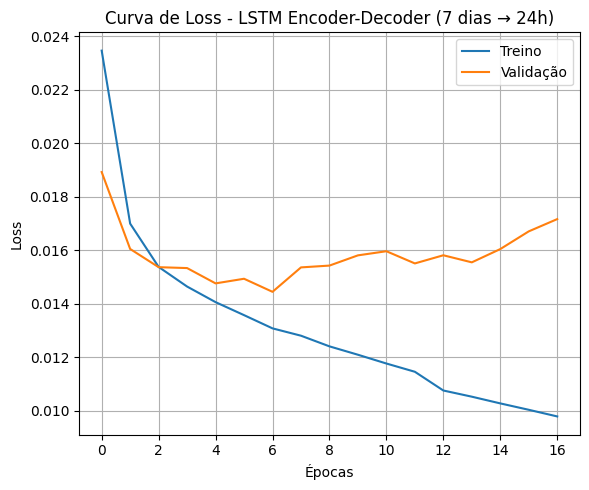

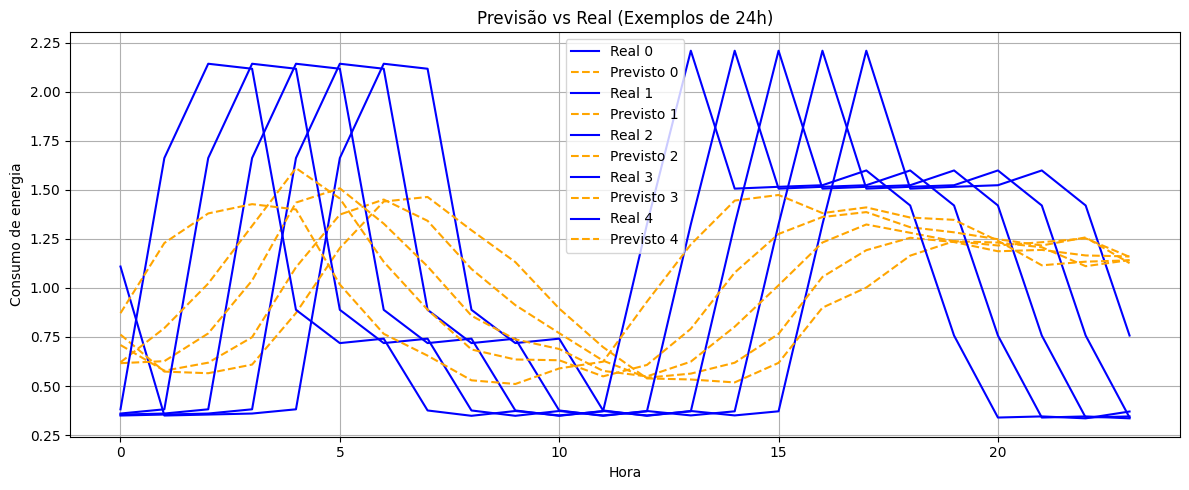

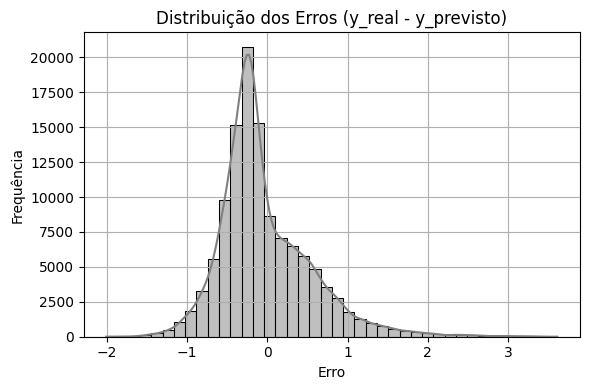

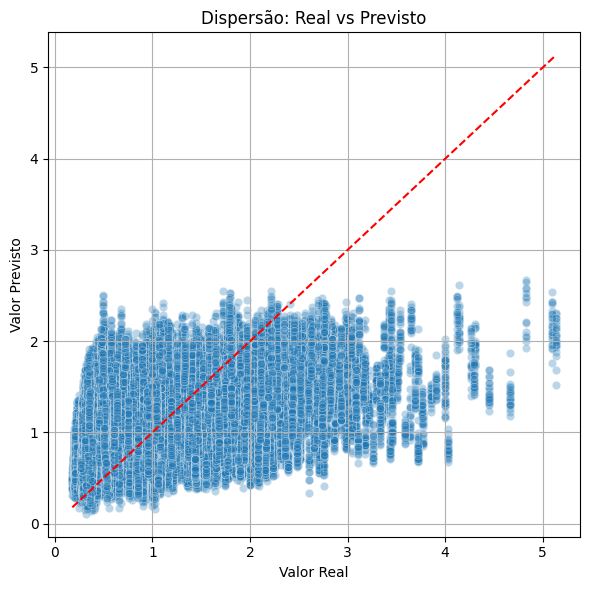

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------- 1. Inverter normalização --------------------
def invert_scale(y_scaled, n_features):
    inv = []
    for yseq in y_scaled:
        yseq = yseq.reshape(-1, 1)  # força (24, 1)
        extended = np.concatenate([yseq, np.zeros((yseq.shape[0], n_features - 1))], axis=1)
        inv_seq = scaler.inverse_transform(extended)[:, 0]
        inv.append(inv_seq)
    return np.array(inv)

y_test_inv = invert_scale(y_test, X.shape[2])
y_pred_inv = invert_scale(y_pred, X.shape[2])

# -------------------- 2. Avaliação --------------------
mae = mean_absolute_error(y_test_inv.flatten(), y_pred_inv.flatten())
rmse = mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten()) ** 0.5
r2 = r2_score(y_test_inv.flatten(), y_pred_inv.flatten())

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# -------------------- 3. Curva de Loss --------------------
plt.figure(figsize=(6, 5))
plt.plot(history.history["loss"], label="Treino")
plt.plot(history.history["val_loss"], label="Validação")
plt.title("Curva de Loss - LSTM Encoder-Decoder (7 dias → 24h)")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------- 4. Previsão vs Real (5 exemplos) --------------------
plt.figure(figsize=(12, 5))
for i in range(5):  # apenas 5 previsões de 24h
    plt.plot(y_test_inv[i], label=f"Real {i}", color='blue')
    plt.plot(y_pred_inv[i], label=f"Previsto {i}", linestyle='--', color='orange')
plt.title('Previsão vs Real (Exemplos de 24h)')
plt.xlabel('Hora')
plt.ylabel('Consumo de energia')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------- 5. Histograma dos erros --------------------
errors = y_test_inv.flatten() - y_pred_inv.flatten()
plt.figure(figsize=(6, 4))
sns.histplot(errors, bins=40, kde=True, color='gray')
plt.title("Distribuição dos Erros (y_real - y_previsto)")
plt.xlabel("Erro")
plt.ylabel("Frequência")
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------- 6. Dispersão Real vs Previsto --------------------
min_val = np.min(y_test_inv)
max_val = np.max(y_test_inv)

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_inv.flatten(), y=y_pred_inv.flatten(), alpha=0.3)
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.title('Dispersão: Real vs Previsto')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.grid(True)
plt.tight_layout()
plt.show()